# Research notebook for backdoor attacks on audio generative diffusion models

The diffusion model used in this notebook was based on a model from an assignment for week 11 of the 2023 Deep Learning course (NWI-IMC070) of the Radboud University.

# Here is the initial code:

In [1]:
%config InlineBackend.figure_formats = ['png']
%matplotlib inline

import torchaudio
import torchvision
import matplotlib.pyplot as plt

from d2l import torch as d2l
import itertools
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch import nn
from torch.nn import functional as F
import os

import sklearn.preprocessing

import joblib

import sounddevice as sd

from IPython.display import Audio

In [2]:
if torch.cuda.is_available():
  device = torch.device('cuda')
else:
  device = torch.device('cpu')

print(device)

print(str(torchaudio.list_audio_backends()))

cuda
['soundfile']


# Parameters

In [3]:
diffusion_steps = 1000
beta = torch.linspace(1e-4, 0.02, diffusion_steps)
alpha = 1.0 - beta
alpha_bar = torch.cumprod(alpha, dim=0)

resize = 32

filename = "thesis-diffusion-poison-" + str(resize)
print(filename)
sample_rate = 16000

thesis-diffusion-poison-32


### Audio data

Load the data

In [4]:
#Initialization of label encoder
le = joblib.load(f"../Data/{filename}-label_encoder.pkl")

# Loading train_loader and validation_loader
train_loader = torch.load(f"../Data/{filename}-train_loader.pth")
validation_loader = torch.load(f"../Data/{filename}-validation_loader.pth")

# Number of classes in the dataset (number of spoken commands)
num_classes = 35

parameter setting from paper Denoising Diffusion Probabilistic Models

In [5]:
# Function to visualize spectrogram
def show_spectrogram(spectrogram, title):
    plt.figure(figsize=(8, 4))
    plt.imshow(spectrogram.log2()[0], aspect='auto', origin='lower')
    plt.colorbar(format='%+2.0f dB')
    plt.title(title)
    plt.xlabel('Time')
    plt.ylabel('Frequency')
    plt.tight_layout()
    plt.show()

In [6]:
def generate_noisy_samples(x_0, beta):
    '''
    Create noisy samples for the minibatch x_0.
    Return the noisy image, the noise, and the time for each sample.
    '''
    
    x_0 = x_0.to(device)  # Ensure the input tensor is on GPU
    beta = beta.to(device)  # Ensure beta is on GPU

    alpha = 1.0 - beta
    alpha_bar = torch.cumprod(alpha, dim=0).to(device)

    # sample a random time t for each sample in the minibatch
    t = torch.randint(beta.shape[0], size=(x_0.shape[0],), device=x_0.device)

    # Generate noise
    noise = torch.randn_like(x_0).to(device)

    # Add the noise to each sample
    x_t = torch.sqrt(alpha_bar[t, None, None, None]) * x_0 + \
          torch.sqrt(1 - alpha_bar[t, None, None, None]) * noise

    return x_t, noise, t

In [7]:
class SelfAttention(nn.Module):
    def __init__(self, h_size):
        super(SelfAttention, self).__init__()
        self.h_size = h_size
        self.mha = nn.MultiheadAttention(h_size, 4, batch_first=True)
        self.ln = nn.LayerNorm([h_size])
        self.ff_self = nn.Sequential(
            nn.LayerNorm([h_size]),
            nn.Linear(h_size, h_size),
            nn.GELU(),
            nn.Linear(h_size, h_size),
        )

    def forward(self, x):
        x_ln = self.ln(x)
        attention_value, _ = self.mha(x_ln, x_ln, x_ln)
        attention_value = attention_value + x
        attention_value = self.ff_self(attention_value) + attention_value
        return attention_value

class SAWrapper(nn.Module):
    def __init__(self, h_size, num_s):
        super(SAWrapper, self).__init__()
        self.sa = nn.Sequential(*[SelfAttention(h_size) for _ in range(1)])
        self.num_s = num_s
        self.h_size = h_size

    def forward(self, x):
        x = x.view(-1, self.h_size, self.num_s * self.num_s).swapaxes(1, 2)
        x = self.sa(x)
        x = x.swapaxes(2, 1).view(-1, self.h_size, self.num_s, self.num_s)
        return x

# U-Net code adapted from: https://github.com/milesial/Pytorch-UNet

class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels, mid_channels=None, residual=False):
        super().__init__()
        self.residual = residual
        if not mid_channels:
            mid_channels = out_channels
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, mid_channels, kernel_size=3, padding=1, bias=False),
            nn.GroupNorm(1, mid_channels),
            nn.GELU(),
            nn.Conv2d(mid_channels, out_channels, kernel_size=3, padding=1, bias=False),
            nn.GroupNorm(1, out_channels),
        )

    def forward(self, x):
        if self.residual:
            return F.gelu(x + self.double_conv(x))
        else:
            return self.double_conv(x)

class Down(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.maxpool_conv = nn.Sequential(
            nn.MaxPool2d(2),
            DoubleConv(in_channels, in_channels, residual=True),
            DoubleConv(in_channels, out_channels),
        )

    def forward(self, x):
        return self.maxpool_conv(x)

class Up(nn.Module):
    def __init__(self, in_channels, out_channels, bilinear=True):
        super().__init__()

        # if bilinear, use the normal convolutions to reduce the number of channels
        if bilinear:
            self.up = nn.Upsample(scale_factor=2, mode="bilinear", align_corners=True)
            self.conv = DoubleConv(in_channels, in_channels, residual=True)
            self.conv2 = DoubleConv(in_channels, out_channels, in_channels // 2)
        else:
            self.up = nn.ConvTranspose2d(
                in_channels, in_channels // 2, kernel_size=2, stride=2
            )
            self.conv = DoubleConv(in_channels, out_channels)

    def forward(self, x1, x2):
        x1 = self.up(x1)
        # input is CHW
        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]

        x1 = F.pad(x1, [diffX // 2, diffX - diffX // 2, diffY // 2, diffY - diffY // 2])
        x = torch.cat([x2, x1], dim=1)
        x = self.conv(x)
        x = self.conv2(x)
        return x

class OutConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(OutConv, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=1)

    def forward(self, x):
        return self.conv(x)

In [8]:
class UNetConditional(nn.Module):
    def __init__(self, c_in=1, c_out=1, n_classes=35, device="cuda"):
        super().__init__()
        self.device = device

        bilinear = True
        self.inc = DoubleConv(c_in, 64)
        self.down1 = Down(64, 128)
        self.down2 = Down(128, 256)
        factor = 2 if bilinear else 1
        self.down3 = Down(256, 512 // factor)
        self.up1 = Up(512, 256 // factor, bilinear)
        self.up2 = Up(256, 128 // factor, bilinear)
        self.up3 = Up(128, 64, bilinear)
        self.outc = OutConv(64, c_out)
        self.sa1 = SAWrapper(256, 8)
        self.sa2 = SAWrapper(256, 4)
        self.sa3 = SAWrapper(128, 8)

        self.label_embedding = nn.Embedding(n_classes, 256)

    def pos_encoding(self, t, channels, embed_size):
        inv_freq = 1.0 / (
            10000
            ** (torch.arange(0, channels, 2, device=self.device).float() / channels)
        )
        pos_enc_a = torch.sin(t[:, None].repeat(1, channels // 2) * inv_freq)
        pos_enc_b = torch.cos(t[:, None].repeat(1, channels // 2) * inv_freq)
        pos_enc = torch.cat([pos_enc_a, pos_enc_b], dim=-1)
        return pos_enc.view(-1, channels, 1, 1).repeat(1, 1, embed_size, embed_size)

    def label_encoding(self, label, channels, embed_size):
        return self.label_embedding(label)[:, :channels, None, None].repeat(1, 1, embed_size, embed_size)

    def forward(self, x, t, label):
        """
        Model is U-Net with added positional encodings and self-attention layers.
        """
        x1 = self.inc(x)
        x2 = self.down1(x1) + self.pos_encoding(t, 128, 16) + self.label_encoding(label, 128, 16)
        x3 = self.down2(x2) + self.pos_encoding(t, 256, 8) + self.label_encoding(label, 256, 8)
        x3 = self.sa1(x3)
        x4 = self.down3(x3) + self.pos_encoding(t, 256, 4) + self.label_encoding(label, 256, 4)
        x4 = self.sa2(x4)
        x = self.up1(x4, x3) + self.pos_encoding(t, 128, 8) + self.label_encoding(label, 128, 8)
        x = self.sa3(x)
        x = self.up2(x, x2) + self.pos_encoding(t, 64, 16) + self.label_encoding(label, 64, 16)
        x = self.up3(x, x1) + self.pos_encoding(t, 64, 32) + self.label_encoding(label, 64, 32)
        output = self.outc(x)
        return output

In [9]:
def train_conditional(model, beta, num_epochs=10, lr=1e-3):

    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    animator = d2l.Animator(xlabel='epoch', xlim=[1, num_epochs], figsize=(10, 5),
                            legend=['train loss', 'validation loss'])
    for epoch in range(num_epochs):
        metric = d2l.Accumulator(2)
        model.train()
        for x, y in train_loader:
            x = x.to(device)
            y = y.to(device)
            optimizer.zero_grad()
            
            # generate a noisy minibatch
            x_t, noise, sampled_t = generate_noisy_samples(x, beta.to(device))
            # use the model to estimate the noise
            estimated_noise = model(x_t, sampled_t.to(torch.float), y)

            # compute the difference between the noise and the estimated noise
            loss = F.mse_loss(estimated_noise, noise)
            
            # Optimize
            loss.backward()
            optimizer.step()
            
            # Track our progress
            metric.add(loss.detach() * x.shape[0], x.shape[0])
        train_loss = metric[0] / metric[1]
            
        # Compute test loss
        validation_loss = test_conditional(model, validation_loader, beta)

        # Plot
        animator.add(epoch + 1, (train_loss, validation_loss))
    print(f'training loss {train_loss:.3g}, validation loss {validation_loss:.3g}')
    os.makedirs("../Models", exist_ok=True)
    torch.save(model.state_dict(), f"./Models/{filename}.pth")

def test_conditional(model, validation_loader, beta):
    metric = d2l.Accumulator(2)
    model.eval()
    for x, y in validation_loader:
        x = x.to(device)
        y = y.to(device)
        with torch.no_grad():
            x_t, noise, sampled_t = generate_noisy_samples(x, beta.to(device))
            estimated_noise = model(x_t, sampled_t.to(torch.float), y)
            loss = F.mse_loss(estimated_noise, noise)
            metric.add(loss.detach() * x.shape[0], x.shape[0])
    return metric[0] / metric[1]

In [10]:
def sample_from_model_conditional(x, model, beta, label):
    # keep track of x at different time steps
    x_hist = []
    with torch.no_grad():
        c = (torch.ones(x.shape[0]) * label).long().to(device)
        # loop over all time steps in reverse order
        for i in reversed(range(0, beta.shape[0])):
            # copy the time step for each sample in the minibatch
            t = (torch.ones(x.shape[0]) * i).long().to(device)
            # generate random noise for early time steps
            z = torch.randn_like(x) if i > 0 else torch.zeros_like(x)
            # define sigma as suggested in the paper
            sigma = torch.sqrt(beta[i])
            # compute the next x
            x = (1 / torch.sqrt(alpha[i])) * \
                (x - ((1 - alpha[i]) / torch.sqrt(1 - alpha_bar[i])) * model(x, t, c)) + \
                sigma * z
            if i % 100 == 0:
                x_hist.append(x.detach().cpu().numpy())
    return x, x_hist

Hotfix

In [11]:
print(le.classes_)
print(len(le.classes_))

['backward' 'bed' 'bird' 'cat' 'dog' 'down' 'eight' 'five' 'follow'
 'forward' 'four' 'go' 'happy' 'house' 'learn' 'left' 'marvin' 'nine' 'no'
 'off' 'on' 'one' 'right' 'seven' 'sheila' 'six' 'stop' 'three' 'tree'
 'two' 'up' 'visual' 'wow' 'yes' 'zero']
35


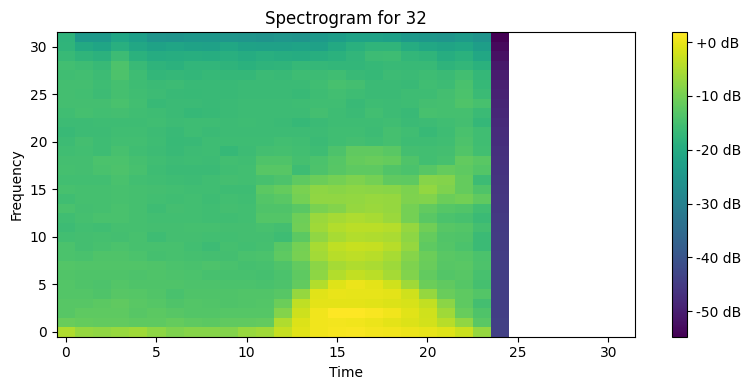

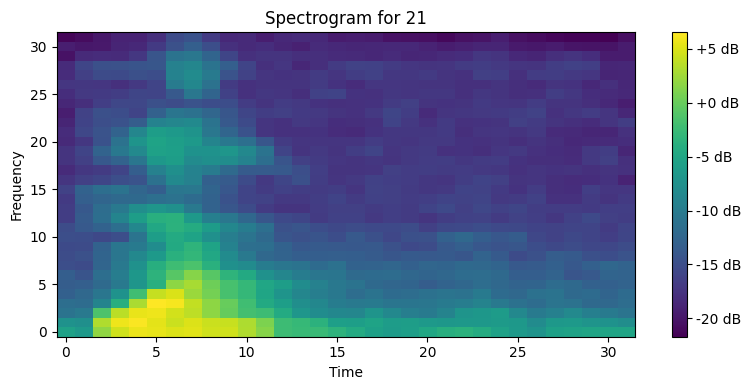

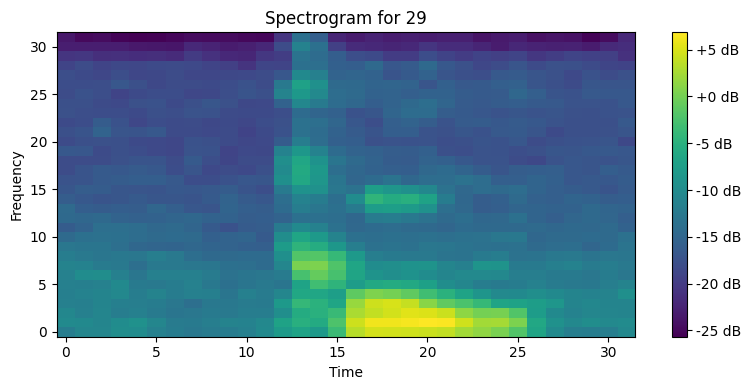

In [12]:
x_0, y = next(iter(train_loader))

# Function to visualize spectrogram
def show_spectrogram(spectrogram, title):
    plt.figure(figsize=(8, 4))
    plt.imshow(spectrogram.log2()[0][0], aspect='auto', origin='lower')
    plt.colorbar(format='%+2.0f dB')
    plt.title(title)
    plt.xlabel('Time')
    plt.ylabel('Frequency')
    plt.tight_layout()
    plt.show()

# Visualize spectrograms for a few samples from the train set
j = 0
for i in train_loader:  # Visualize first 3 samples
    if j < 3:
        show_spectrogram(i[0], f'Spectrogram for {i[1][0]}')
        j += 1
    else:
        break        


In [13]:
loaded_model = UNetConditional()
loaded_model.load_state_dict(torch.load(f"../Models/{filename}-model.pth"))
loaded_model = loaded_model.to(device)

In [14]:
def plot_x_hist(x_hist):
    # plot the generated images
    plt.figure(figsize=(20, 15))
    for i in range(len(x_hist)):
        for j in range(10):
            plt.subplot(10, len(x_hist), j * len(x_hist) + i + 1)
            spectrogram = x_hist[i][j]
            # Clip spectrogram to remove negative values
            spectrogram = np.clip(spectrogram[0], a_min=1e-10, a_max=None)
            # Apply log2 to the clipped spectrogram
            spectrogram = np.log2(spectrogram + 1e-10)
            plt.imshow(spectrogram, aspect='auto', origin='lower')
            plt.colorbar(format='%+2.0f dB')
            plt.title(f'Spectrogram {j * 10 + i}')
            plt.xlabel('Time')
            plt.ylabel('Frequency')
            plt.tight_layout()

C:\Users\neder\AppData\Local\Temp\ipykernel_5524\626963326.py:17: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


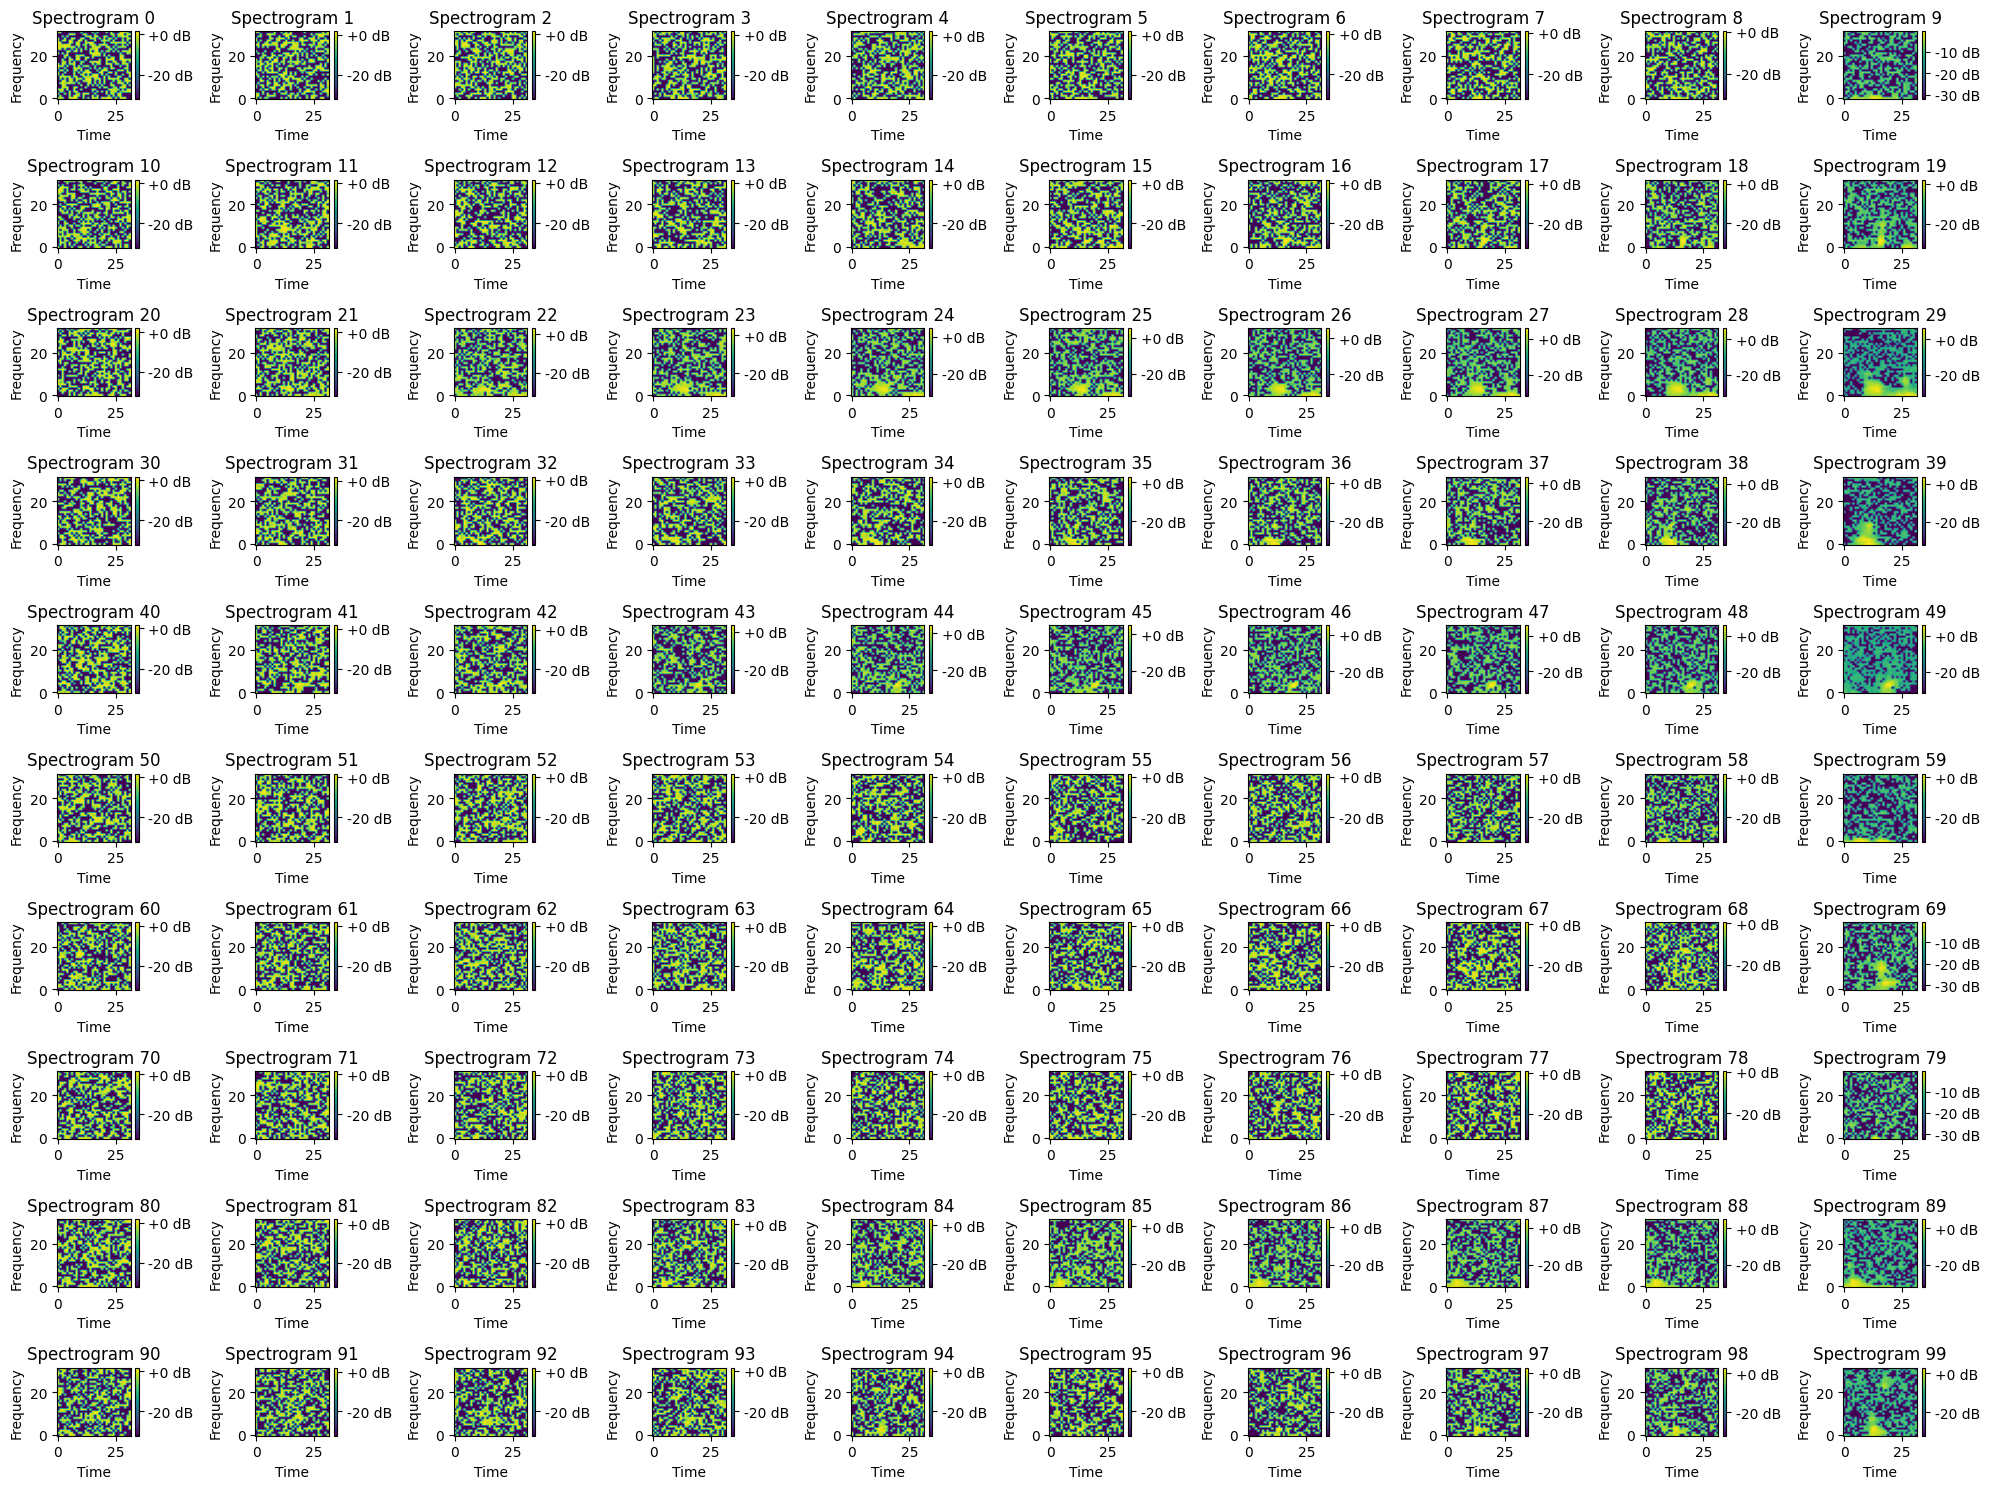

In [15]:
x = torch.randn_like(x_0[:10]).to(device)
x, x_hist = sample_from_model_conditional(x, loaded_model, beta, label=3)
plot_x_hist(x_hist)

# Sample and plot 10 samples for every digit

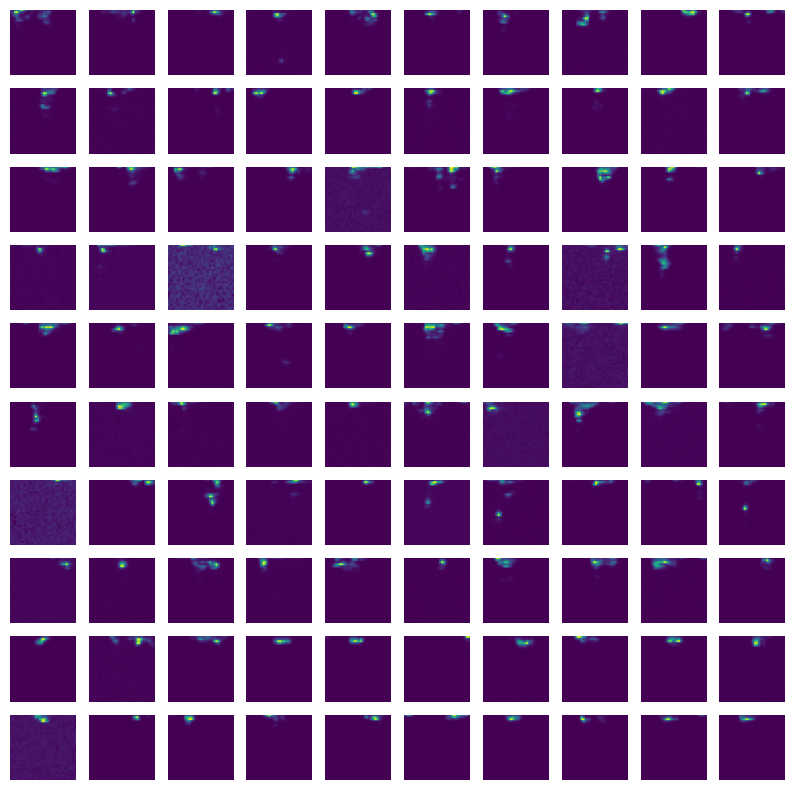

In [16]:
x_per_class = []
for label in range(10):
    # sample 10 digits with this label
    x = torch.randn_like(x_0[:10]).to(device)
    x, x_hist = sample_from_model_conditional(x, loaded_model, beta, label=label)
    x_per_class.append(x.detach().cpu().numpy())

plt.figure(figsize=(10, 10))
for i in range(10):
    for j in range(10):
        plt.subplot(10, 10, j * 10 + i + 1)
        plt.imshow(x_per_class[j][i, 0])
        plt.axis('off')

In [17]:
x = torch.randn_like(x_0[:10]).to(device)
x, x_hist = sample_from_model_conditional(x, loaded_model, beta, label=3)

torch.Size([1, 32, 32])


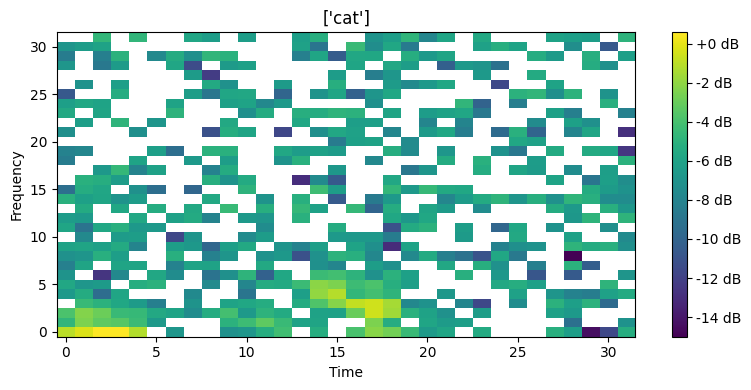

In [18]:
def show_spectrogram(spectrogram, title):
    plt.figure(figsize=(8, 4))
    plt.imshow(spectrogram.log2()[0], aspect='auto', origin='lower')
    plt.colorbar(format='%+2.0f dB')
    plt.title(title)
    plt.xlabel('Time')
    plt.ylabel('Frequency')
    plt.tight_layout()
    plt.show()

print(x[9].cpu().shape)
show_spectrogram(x[9].cpu(), le.inverse_transform([3]))

In [23]:
# Define a transform to convert waveform to spectrogram
InverseTransform = torchvision.transforms.Compose([
    torchvision.transforms.Resize((201, 81)),
    torchaudio.transforms.InverseSpectrogram(),
])

print(x[9].cpu().shape)
x_wav = InverseTransform(x[9].cpu().to(torch.complex128))
print(x_wav.cpu().shape)

Audio(x_wav, rate=sample_rate)

torch.Size([1, 32, 32])
torch.Size([1, 16000])
